# Training and Serving TensorFlow models on AI Platform using R Interface
## Overview

This notebook illustrates how to use [R interface for TensorFlow](https://tensorflow.rstudio.com/) to build an ML model to estimate the baby's weight given a number of factors, using the [BigQuery natality dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality&page=table&_ga=2.99329886.-1705629017.1551465326&_gac=1.109796023.1561476396.CI2rz-z4hOMCFc6RhQods4oEXA). We use [AI Platform Training](https://cloud.google.com/ml-engine/docs/tensorflow/training-overview) to train the TensorFlow model at scale, and then use the [AI Platform Prediction](https://cloud.google.com/ml-engine/docs/tensorflow/prediction-overview) to serve the trained model for online predictions.

R is one of the most widely used programming languages for statistical modeling, which has a large and active community of data scientists and ML professional. 
With over 10,000 packages in the open-source repository of CRAN, R caters to all statistical data analysis applications, ML, and visualisation.


## Dataset
The dataset used in this tutorial is natality data, which describes all United States births registered in the 50 States, the District of Columbia, and New York City from 1969 to 2008, with more than 137 million records.
The dataset is available in [BigQuery public dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality&page=table&_ga=2.99329886.-1705629017.1551465326&_gac=1.109796023.1561476396.CI2rz-z4hOMCFc6RhQods4oEXA). We use the data extracted from BigQuery and stored as CSV in Cloud Storage (GCS) in the [Exploratory Data Analysis](01_EDA-with-R-and-BigQuery) notebook.

In this notebook, we focus on Exploratory Data Analysis, while the goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.

## Objective
The goal of this tutorial is to:
1. Create a TensorFlow premade Estimator trainer using R interface
2. Train and export the Estimator on AI Platform Training using the cloudml APIs
3. Deploy the exported model to AI Platform prediction using the cloudml APIs
4. Invoke the deployed model API for predictions.


## Costs
This tutorial uses billable components of Google Cloud Platform (GCP):
1. Create a TensorFlow premade Estimator trainer using R interface
2. Train and export the Estimator on AI Platform Training using the cloudml APIs
3. Deploy the exported model to AI Platform prediction using the cloudml APIs
4. Invoke the deployed model API for predictions.
5. Use the AI Platform Notebooks to drive the workflow.


Learn about GCP pricing, use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## 0. Setup

In [1]:
install.packages(c("tfestimators", "tfdatasets", "cloudml"))

Installing packages into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)


In [2]:
library(tfestimators) # used for creating tensorflow estimators
library(tfdatasets) # used for creating data input functions
library(cloudml) # used for training and deploying models to AI Platform
install_tensorflow()

Loading required package: tfruns


Creating virtualenv for TensorFlow at  ~/.virtualenvs/r-tensorflow 
Installing TensorFlow ...

Installation complete.



In [4]:
# Set the project id
PROJECT_ID <- "dsparing_sandbox"

# Set yout GCS bucket
BUCKET_NAME <- "spd_r_gcp" 

# Set your training and model deployment region
REGION <- 'us-central1'

## 1. Building the TensorFlow Estimator

### 1.1. Create feature columns

In [5]:
# numerical columns
mother_age <- tf$feature_column$numeric_column("mother_age")
plurality <- tf$feature_column$numeric_column('plurality')
gestation_weeks <- tf$feature_column$numeric_column('gestation_weeks')


# categorical columns
is_male <- tf$feature_column$categorical_column_with_vocabulary_list("is_male", vocabulary_list = c("True", "False"))
mother_race <- tf$feature_column$categorical_column_with_vocabulary_list(
    'mother_race', vocabulary_list = c('1', '2', '3', '4', '5', '6', '7', '8', '9', '18', '28', '38', '48', '58', '69', '78'))
mother_married <- tf$feature_column$categorical_column_with_vocabulary_list('mother_married', c('True', 'False'))
cigarette_use <- tf$feature_column$categorical_column_with_vocabulary_list('cigarette_use', c('True', 'False', 'None'))
alcohol_use <- tf$feature_column$categorical_column_with_vocabulary_list('alcohol_use', c('True', 'False', 'None'))

# extended feature columns
cigarette_use_X_alcohol_use = tf$feature_column$crossed_column(c("cigarette_use", "alcohol_use"), 9)
mother_race_embedded = tf$feature_column$embedding_column(mother_race, 3)
mother_age_bucketized = tf$feature_column$bucketized_column(mother_age, boundaries=c(18, 22, 28, 32, 36, 40, 42, 45, 50))  
mother_race_X_mother_age_bucketized = tf$feature_column$crossed_column(c(mother_age_bucketized, "mother_race"),  120)   
mother_race_X_mother_age_bucketized_embedded = tf$feature_column$embedding_column(mother_race_X_mother_age_bucketized, 5)
    
# wide and deep columns
wide_columns <- feature_columns(
    is_male, mother_race, plurality, mother_married, cigarette_use, alcohol_use, cigarette_use_X_alcohol_use, mother_age_bucketized) 
deep_columns <- feature_columns(
    mother_age, gestation_weeks, mother_race_embedded, mother_race_X_mother_age_bucketized_embedded)


Warning message:
“`quo_expr()` is deprecated as of rlang 0.2.0.
Please use `quo_squash()` instead.
This warning is displayed once per session.”

### 1.2. Instantiate Estimator

We use the premade [dnn_linear_combined_regressor](https://tensorflow.rstudio.com/tfestimators/reference/dnn_linear_combined_estimators.html). This is a [Wide & Deep](https://arxiv.org/abs/1606.07792) model that is useful for generic large-scale regression problems with sparse input features (e.g., categorical features with a large number of possible feature values) and dense input features (numerical features).

In [6]:
model_dir = 'models/tf_babyweight_estimator'

model <- dnn_linear_combined_regressor(
    model_dir = model_dir,
    linear_feature_columns = wide_columns,
    dnn_feature_columns = deep_columns,
    dnn_optimizer = "Adagrad",
    linear_optimizer = "Ftrl",
    dnn_hidden_units = c(64, 64),
    dnn_activation_fn = "relu", 
    dnn_dropout = 0.1,
)

### 1.3. Define data input functions
If you run the [Exploratory Data Analysis](01_EDA-with-R-and-BigQuery) Notebook, you should have the **train_data.csv** and **eval_data.csv** files uploaded to GCS. You can download them to train your model locally using the following cell. However, if you have the files available locally, you can skip the following cell.

In [7]:
dir.create(file.path('data'), showWarnings = FALSE)
gcs_data_dir <- paste0("gs://", BUCKET_NAME, "/data/*_data.csv")
gsutil_exec("cp", "-r", gcs_data_dir, "data/")

Create data input function for training and evaluation, based on the data files. 

In [8]:
train_file <- "data/train_data.csv"
eval_file <- "data/eval_data.csv"
header <- c(
    "weight_pounds", 
    "is_male", "mother_age", "mother_race", "plurality", "gestation_weeks", 
    "mother_married", "cigarette_use", "alcohol_use", 
    "key")
types <- c(
    "double", 
    "character", "double", "character", "double", "double", 
    "character", "character", "character", 
    "character")

target <- "weight_pounds"
key <- "key"
features <- setdiff(header, c(target, key))

data_input_fn <- function(data, batch_size, num_epochs = 1, shuffle = FALSE) {
  input_fn(data, features = features, response = target, 
           batch_size = batch_size, shuffle = shuffle, num_epochs = num_epochs)
}

train_data <- read.table(train_file, col.names = header, sep=",", colClasses = types)
eval_data <- read.table(eval_file, col.names = header, sep=",", colClasses = types)

## 2. Train, Evaluate, and Export the Estimator

### 2.1. Train the estimator

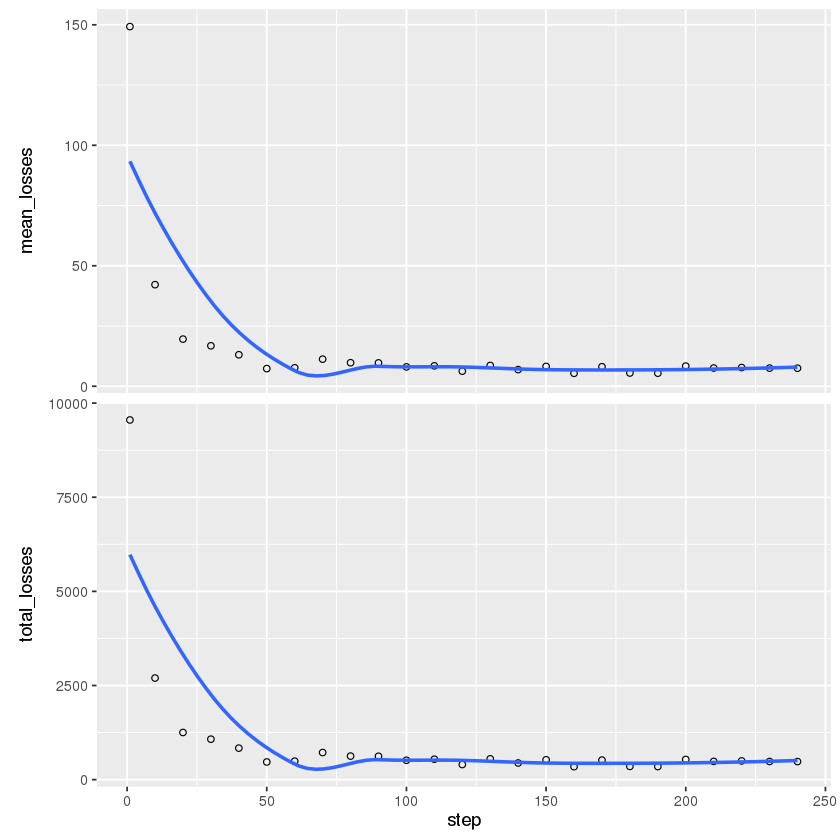

In [9]:
batch_size = 64
num_epochs = 2

unlink(model_dir, recursive = TRUE)

history <- train(
    model, 
    input_fn = data_input_fn(train_data, batch_size = batch_size, num_epochs = num_epochs, shuffle = TRUE)
)

plot(history)

### 2.2. Evaluate the trained estimator

In [10]:
evaluate(
    model, 
    input_fn = data_input_fn(eval_data, batch_size = batch_size)
)

label/mean,average_loss,global_step,prediction/mean,loss
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.289072,1.553401,241,7.524918,98.24211


### 2.3. Export trained estimator

In [11]:
feature_spec <- list()
for (i in 1:length(header)) {
    column <- header[i]
    if (column %in% features) {
        
        default_value = 'NA'
        column_type <- types[i]
        
        if (column_type != 'character'){
            default_value = 0
        }
        
        default_tensor <- tf$constant(value = default_value, shape = shape(1, 1))
        feature_spec[[column]] <- tf$placeholder_with_default(
            input = default_tensor, shape = shape(NULL, 1))
    }   
}  
            
serving_input_receiver_fn <- tf$estimator$export$build_raw_serving_input_receiver_fn(feature_spec)

saved_model_dir = paste0(model_dir, '/export')
export_savedmodel(model, saved_model_dir, serving_input_receiver_fn = serving_input_receiver_fn)
print(paste("Model exported to:", saved_model_dir))

[1] "Model exported to: models/tf_babyweight_estimator/export"


## 3. Submit a Training Job to AI Platform
In order to train your TensorFlow estimator in at scale using AI Platform Training, you need to write your training implementation in a [model_trainer.R](src/tensorflow/model_trainer) file. The file includes the code in the previous cells to create, train, evaluate, and export the TensorFlow dnn_linear_combined_regressor model.

In [12]:
# install and load required packages
install.packages(c("caret", "plumber", "rjson", "foreach"))

cloudml_train('src/tensorflow/model_trainer.R', region = REGION)

Installing packages into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)
Submitting training job to CloudML...
Job 'cloudml_2019_07_25_065504438' successfully submitted.

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/cloudml_2019_07_25_065504438?project=dsparing-sandbox

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2019_07_25_065504438&project=dsparing-sandbox

Check job status with:     job_status("cloudml_2019_07_25_065504438")

Collect job output with:   job_collect("cloudml_2019_07_25_065504438")

After collect, view with:  view_run("runs/cloudml_2019_07_25_065504438")



In [13]:
model_name <- 'tf_babyweight_estimator'
gcs_model_dir <- paste0("gs://", BUCKET_NAME, "/models/", model_name)
gsutil_exec("ls", gcs_model_dir, echo = TRUE)

CommandException: One or more URLs matched no objects.


ERROR: Error: ERROR: gcloud invocation failed [exit status 1]

[command]
/usr/lib/google-cloud-sdk/bin/gsutil ls gs://spd_r_gcp/models/tf_babyweight_estimator

[output]


[errmsg]
CommandException: One or more URLs matched no objects.



## 4. Deploy the trained model to AI Platform Prediction
If you train your model using the model_trainer.R in AI Platform, it will upload the saved model to GCS. However, if you train your model locally and have your saved model locally, you need to upload it to GCS.

### (Optional) 4.0. Upload the saved model to GCS

In [ ]:
model_name <- 'tf_babyweight_estimator'
gcs_model_dir <- paste0("gs://", BUCKET_NAME, "/models/", model_name)
gsutil_exec("cp", "-r", saved_model_dir, gcs_model_dir)

### 4.1. Create a model

In [ ]:
gcloud_exec("ai-platform", "models", "list")

# Create model
model_name <- 'tf_babyweight_estimator'
gcloud_exec("ai-platform", "models", "create", model_name, "--regions", REGION)

# List models
gcloud_exec("ai-platform", "models", "list")

### 4.2. Create a model version 

In [ ]:
# Create version
model_version <- 'v01'
framework <- 'tensorflow'
runtime_version <- '1.14'

gcloud_exec("ai-platform", "versions", "create", model_version, 
            "--model", model_name, 
            "--framework", framework,
            "--runtime-version", runtime_version,
            "--origin", gcs_model_dir
           )

# List versions
gcloud_exec("ai-platform", "versions", "list", "--model", model_name)

## 5. Invoke the Model API for Predictions

In [ ]:
library("rjson")

model_version <- 'v01'

instances_string <- '
[
    {
        "is_male": ["TRUE"],
        "mother_age": [28],
        "mother_race": ["8"],
        "plurality": [1],
        "gestation_weeks":  [18],
        "mother_married": ["TRUE"],
        "cigarette_use": ["FALSE"],
        "alcohol_use": ["FALSE"]
     }    
]
'

instances <- jsonlite::fromJSON(instances_string, simplifyVector = FALSE)
predictions <- cloudml_predict(instances, model_name, version = model_version, verbose = TRUE)
print(paste("Estimated weight(s):", predictions))

# License

Authors: Daniel Sparing & Khalid Salama

---
**Disclaimer**: This is not an official Google product. The sample code provided for an educational purpose.

---

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.